# ENV

In [1]:
import os
import glob
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
# 현재 OS 및 라이브러리 버전 체크 체크

current_os = platform.system()
print(f"Current OS: {current_os}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"CUDA: {torch.cuda.is_available()}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")


Current OS: Linux
CUDA: True
Tesla V100-PCIE-32GB
Python Version: 3.8.5
torch Version: 1.7.1
torchvision Version: 0.8.2


In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

In [4]:
train_path = '../input/data/train'
train_image_path = os.path.join(train_path, 'images')

# 모든 train data path 가져와 라벨링

In [5]:
all_path = glob.glob(train_image_path + '/*/*')

In [6]:
print('2700명 * 이미지 7장 =', len(all_path))
all_path[:10]

2700명 * 이미지 7장 = 18900


['../input/data/train/images/005556_male_Asian_50/mask2.jpg',
 '../input/data/train/images/005556_male_Asian_50/incorrect_mask.jpg',
 '../input/data/train/images/005556_male_Asian_50/mask3.jpg',
 '../input/data/train/images/005556_male_Asian_50/normal.jpg',
 '../input/data/train/images/005556_male_Asian_50/mask1.jpg',
 '../input/data/train/images/005556_male_Asian_50/mask4.jpg',
 '../input/data/train/images/005556_male_Asian_50/mask5.jpg',
 '../input/data/train/images/006566_female_Asian_19/mask2.jpg',
 '../input/data/train/images/006566_female_Asian_19/incorrect_mask.jpg',
 '../input/data/train/images/006566_female_Asian_19/mask3.jpg']

In [7]:
# 파일 확장자 종류 확인
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)

['.jpg', '.png', '.jpeg']


In [8]:
all_path.sort()
# all_path

In [9]:
# mislabel
mask_ids = ['000020', '004418', '005227']
gender_ids = ['001498-1', '004432', '006359', '006360', '006361', '006362', '006363', '006364']

# 라벨링 함수
def labeling(path):
    label = 0
    info, mask = path.split('/')[-2:]
    info_lst = info.split('_')
    id, gender, age = info_lst[0], info_lst[1], int(info_lst[-1])
    if mask.startswith('incorrect'):
        if id in mask_ids:
            label += 12
        else: 
            label += 6
    elif mask.startswith('normal'):
        if id in mask_ids:
            label += 6
        else:
            label += 12
    if  gender == 'female':
        if id in gender_ids:
            pass
        else:
            label += 3
    else:
        if id in gender_ids:
            label += 3
    if 30<=age < 58: ###
        label += 1
    elif age >= 58: ###
        label += 2
    return label

In [10]:
def person(path):
    info = path.split('/')[-2]
    id = info.split('_')[0]
    return id

In [11]:
train_path_label_df = pd.DataFrame(all_path, columns=['path'])
train_path_label_df['label'] = train_path_label_df['path'].map(lambda x: labeling(x))
train_path_label_df['id'] = train_path_label_df['path'].map(lambda x: person(x))

train_path_label_df

,path,label,id
0,../input/data/train/images/000001_female_Asian...,10,000001
1,../input/data/train/images/000001_female_Asian...,4,000001
2,../input/data/train/images/000001_female_Asian...,4,000001
3,../input/data/train/images/000001_female_Asian...,4,000001
4,../input/data/train/images/000001_female_Asian...,4,000001
...,...,...,...
18895,../input/data/train/images/006959_male_Asian_1...,0,006959
18896,../input/data/train/images/006959_male_Asian_1...,0,006959
18897,../input/data/train/images/006959_male_Asian_1...,0,006959
18898,../input/data/train/images/006959_male_Asian_1...,0,006959


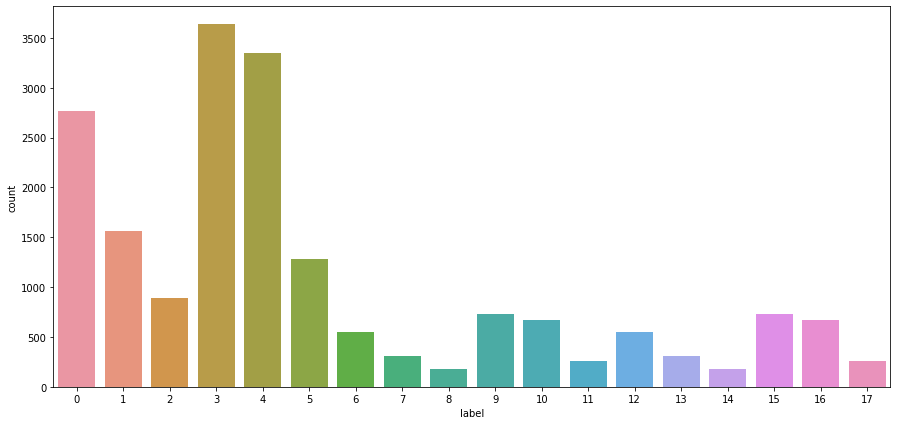

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x='label', data=train_path_label_df, ax=ax)

# CustomDataset 만들기

In [14]:
class MyDataset(Dataset):
    def __init__(self, img_path_label, transform):
        self.X = img_path_label['path']
        self.y = img_path_label['label']
        self.transform = transform
        
            
    def __getitem__(self, idx):
        image = Image.open(self.X.iloc[idx])
        label = self.y.iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.X)

In [15]:
transform = transforms.Compose([Resize((512, 384), Image.BILINEAR),
                               ToTensor(),
                               Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
                              ])

## train test split 
(같은 사람 이미지가 train과 test에 동시에 들어가지 않도록, id를 기준으로 8:2 구분 후 mask 정보 추가)

In [16]:
def age(x):
    if x < 30:
        return 0
    elif x < 58: ###
        return 1
    else:
        return 2

train_df = pd.read_csv('../input/data/train/train.csv')
train_df.gender.replace({'male':0, 'female':1}, inplace=True)
train_df.age = train_df.age.apply(lambda x: age(x))
train_df

,id,gender,race,age,path
0,000001,1,Asian,1,000001_female_Asian_45
1,000002,1,Asian,1,000002_female_Asian_52
2,000004,0,Asian,1,000004_male_Asian_54
3,000005,1,Asian,2,000005_female_Asian_58
4,000006,1,Asian,2,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,0,Asian,0,006954_male_Asian_19
2696,006955,0,Asian,0,006955_male_Asian_19
2697,006956,0,Asian,0,006956_male_Asian_19
2698,006957,0,Asian,0,006957_male_Asian_20


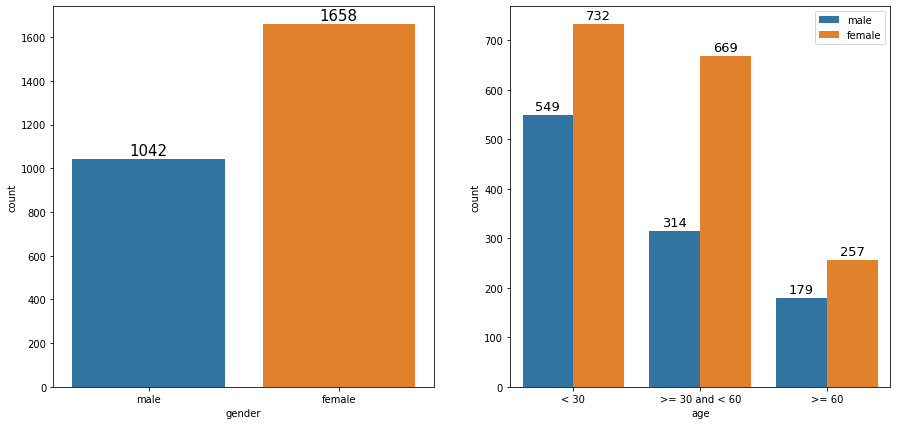

In [17]:
# 성별, 나이에 따른 성별 분포 시각화

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax0 = sns.countplot(x='gender', data=train_df, ax=axes[0])
ax1 = sns.countplot(x="age", data=train_df, ax=axes[1], hue='gender')

ax0.set_xticklabels(['male', 'female'])
ax1.set_xticklabels(['< 30', '>= 30 and < 60', '>= 60'])
ax1.legend(['male', 'female'])

for p in ax0.patches:
        ax0.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20), fontsize=15)
for p in ax1.patches:
        ax1.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10), fontsize=13)

plt.show()

In [ ]:
# age 비율 비슷하게 사람들 나눔
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df, test_size=0.2,
                                      shuffle=True, stratify=train_df['age'],
                                      random_state = 42)

In [19]:
# mask 정보까지 포함
train_set = train_path_label_df[train_path_label_df['id'].isin(train_set['id'])]
val_set = train_path_label_df[train_path_label_df['id'].isin(val_set['id'])]

In [20]:
train_set.shape, val_set.shape

((15120, 3), (3780, 3))

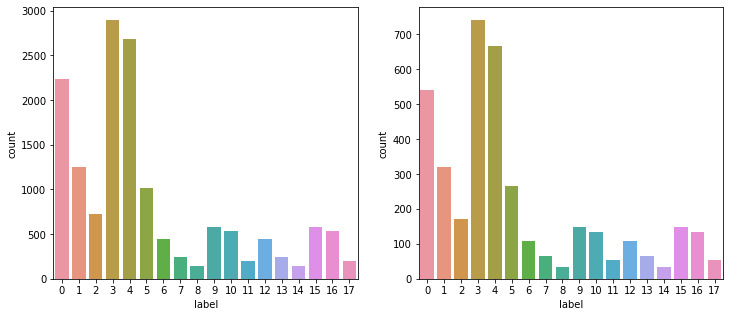

In [21]:
# train val set 라벨 시각화
import seaborn as sns
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x='label', data=train_set, ax=axes[0])
sns.countplot(x='label', data=val_set, ax=axes[1])

In [22]:
BATCH_SIZE = 64

train_dataset = MyDataset(train_set, transform)
val_dataset = MyDataset(val_set, transform)

WeightedRandomSampler

In [25]:
# class_counts = train_set['label'].value_counts().to_list()
# num_samples = sum(class_counts) # 전체 데이터 갯수
# labels = train_set['label'].to_list()
# #클래스별 가중치 부여 
# class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))] 
# # 해당 데이터의 label에 해당되는 가중치
# weights = [class_weights[labels[i]] for i in range(int(num_samples))] #해당 레이블마다의 가중치 비율
# sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# DataLoader

In [23]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
#                          samplermpler=sampler
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False
                            )

In [24]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

# Model
pretrained resnet18 without freeze

In [25]:
resnet18 = torchvision.models.resnet18(pretrained=True) # Model

In [26]:
import math

num_classes = 18

input_features_fc_layer = resnet18.fc.in_features   # fc layer 채널 수 얻기
resnet18.fc = nn.Linear(input_features_fc_layer, num_classes, bias=False)   # fc layer 수정

In [27]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train 

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [29]:
resnet18.to(device)

LR = 0.0001
NUM_EPOCH = 5

criterion = FocalLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=LR)

dataloaders = {
    'train': train_dataloader,
    'test': val_dataloader
}

In [30]:
# 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

train_losses, val_losses,  train_accs, val_accs= [], [], [], []

for epoch in range(1, NUM_EPOCH+1):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            resnet18.train()    # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"):  # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = criterion(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step()    # 계산된 gradient를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0)    # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data)  # 한 Batch에서의 Accuracy 값 저장

        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        # plot 그리기 위해
        if phase == "train":
            train_losses.append(epoch_loss) 
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        
        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc:  # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.386, 평균 Accuracy : 0.793
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.199, 평균 Accuracy : 0.819
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.049, 평균 Accuracy : 0.957
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.262, 평균 Accuracy : 0.815
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.011, 평균 Accuracy : 0.994
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.263, 평균 Accuracy : 0.821
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.004, 평균 Accuracy : 0.998
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.273, 평균 Accuracy : 0.834
현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.999
현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.273, 평균 Accuracy : 0.839
학습 종료!
최고 accuracy : 0.8391534686088562, 최고 낮은 loss : 0.1991131420498566


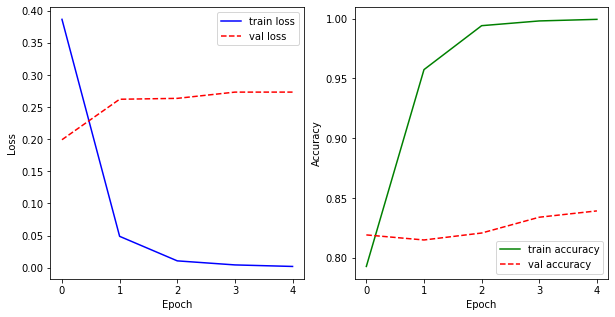

In [32]:
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
# loss = [i.detach().numpy() for i in losses]
plt.plot(train_losses, 'b-', label='train loss') 
plt.plot(val_losses, 'r--', label='val loss') 
plt.legend()

plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(train_accs, 'g-', label='train accuracy') 
plt.plot(val_accs, 'r--', label='val accuracy') 
plt.legend()
plt.show()

실제 정답과 pred 비교하려고, path pred target을 df 만듦

In [33]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)

            result.append([raw_data.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [34]:
valid_testing_dataloader = DataLoader(val_dataset, shuffle=False)

check_eval_df = check_eval(val_set, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,../input/data/train/images/000007_female_Asian...,10,11
1,../input/data/train/images/000007_female_Asian...,4,5
2,../input/data/train/images/000007_female_Asian...,4,5
3,../input/data/train/images/000007_female_Asian...,4,5
4,../input/data/train/images/000007_female_Asian...,4,5
...,...,...,...
3775,../input/data/train/images/006945_male_Asian_1...,0,0
3776,../input/data/train/images/006945_male_Asian_1...,0,0
3777,../input/data/train/images/006945_male_Asian_1...,0,0
3778,../input/data/train/images/006945_male_Asian_1...,0,0


잘못 예측한 데이터만 모아봄

In [35]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df


,path,pred,target
0,../input/data/train/images/000007_female_Asian...,10,11
1,../input/data/train/images/000007_female_Asian...,4,5
2,../input/data/train/images/000007_female_Asian...,4,5
3,../input/data/train/images/000007_female_Asian...,4,5
4,../input/data/train/images/000007_female_Asian...,4,5
...,...,...,...
603,../input/data/train/images/006269_female_Asian...,3,9
604,../input/data/train/images/006511_male_Asian_1...,6,0
605,../input/data/train/images/006684_male_Asian_1...,3,0
606,../input/data/train/images/006684_male_Asian_1...,3,0


틀린 데이터 보려고 이미지 출력 (저작권 상 비공개)

In [40]:
def draw_(df):
    plt.figure(figsize=(15,30))
    row = 7
    for i in range(30):
        plt.subplot(row+1, 30//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target: {df['target'][i]}, pred: {df['pred'][i]}", size=20)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
draw_(wrong_df)
# 주로 age 정보 틀리는 것을 알 수 있음

In [42]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.7646365925420411

# Inference

## 0. Libarary 불러오기 및 경로설정

In [45]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [46]:
# 테스트 데이터셋 폴더 경로를 지정
test_dir = '/opt/ml/input/data/eval'

## 1. Model 정의

In [3]:
# 위에서 학습한 모델 사용

## 2. Test Dataset 정의

In [47]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [48]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = resnet18.to(device) # 위에서 학습한 모델!
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
